In [1]:
# ============================================================================
# Aureus Sigma Capital - Phase 26b: Pilot Strategy Validation Backtest
# Notebook: 26b_pilot_strategy_validation_backtest.ipynb
#
# Objective:
#   To conduct a full, institutional-grade historical backtest of the exact
#   `Composite_Q_20` strategy configuration selected for the live pilot
#   deployment. This notebook will generate the definitive performance tearsheet
#   and metrics for this model over the high-liquidity period (2020-2025) to
#   serve as the official performance benchmark.
# ============================================================================
#
# --- STRATEGY & ENGINE SPECIFICATION ---
#
# *   **Strategy Validated**: `Composite_Q_20`
#     -   **Backtest Period**: 2020-01-01 to 2025-07-31
#     -   **Universe**: Top 200 liquid stocks (>10B VND ADTV)
#     -   **Rebalancing**: Quarterly
#     -   **Portfolio Size**: 20 stocks
#     -   **Signal**: Static QVM composite with V:50%, Q:25%, M:20%, R:5% weights.
#
# *   **Execution Engine**: A backtesting engine implementing the validated logic
#     from `PortfolioEngine_v5.2`, including the non-linear ADTV cost model and
#     hybrid portfolio construction (Fixed-N for small universes).
#
# --- METHODOLOGY WORKFLOW ---
#
# This notebook will execute a full, end-to-end backtest:
#
# 1.  **Setup & Configuration**: Load libraries and define the exact `LIVE_CONFIG`
#     parameters. This ensures a 1:1 match between this backtest and the live
#     portfolio generation script.
# 2.  **Data Ingestion**: Load all factor, price, and benchmark data for the
#     entire 2020-2025 backtest period.
# 3.  **The Backtesting Loop**:
#     a.  Iterate through all quarterly rebalance dates in the period.
#     b.  For each date, construct the point-in-time liquid universe.
#     c.  Fetch factor scores and re-normalize them within the liquid universe.
#     d.  Combine factors using the fixed `LIVE_CONFIG` weights to create the final signal.
#     e.  Construct the top-20 stock portfolio.
#     f.  Store the target portfolio weights for each day until the next rebalance.
# 4.  **Return & Cost Calculation**:
#     a.  Calculate gross daily returns based on the portfolio holdings.
#     b.  Implement the non-linear ADTV cost model from Phase 25c to calculate
#         realistic transaction costs at each rebalance.
#     c.  Compute the final net returns series.
# 5.  **Performance Analysis & Reporting**: Generate a full institutional tearsheet
#     and a summary table of key performance metrics (Sharpe Ratio, Max Drawdown,
#     CAGR, etc.) for the strategy versus the VN-Index.
#
# --- DATA DEPENDENCIES ---
#
# *   **Database**: `alphabeta` (Production)
# *   **Tables**:
#     -   `factor_scores_qvm` (strategy_version='qvm_v2.0_enhanced')
#     -   `equity_history` (for prices and returns)
#     -   `vcsc_daily_data_complete` (for ADTV calculation)
#
# --- EXPECTED OUTPUTS ---
#
# 1.  **Primary Deliverable**: An institutional tearsheet visualizing the
#     strategy's performance, drawdown, and rolling Sharpe ratio vs. the VN-Index.
# 2.  **Secondary Deliverable**: A summary table of key performance metrics,
#     providing the final, definitive statistics for this strategy configuration.
# 3.  **Final Verdict**: A clear assessment of whether the strategy's performance
#     in this period meets our preliminary targets (e.g., Sharpe > 1.5).
#
# --- CRITICAL LINK TO LIVE DEPLOYMENT ---
#
# The results of this notebook serve as the official performance expectation
# for the portfolio generated in `26_live_pilot_portfolio_generation.ipynb`.
# The configuration, engine logic, and methodology must remain identical
# between the two notebooks to ensure integrity.
#

In [2]:
# ============================================================================
# CELL 2: SETUP & CONFIGURATION (v1.1 - Corrected Pathing)
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# --- Add Project Root to Python Path (Corrected Logic) ---
# This logic is more robust and will find the project root regardless of notebook location.
try:
    # Start from the current working directory
    current_path = Path.cwd()
    # Traverse up the directory tree until we find a folder named 'production'
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.universe.constructors import get_liquid_universe_dataframe
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    # Halt execution if modules are not found
    raise

# --- Live Pilot Configuration (Mirrored from 26_live_pilot_portfolio_generation.ipynb) ---
# This configuration block is the single source of truth for the strategy being validated.
# It is based on the best-performing 'Composite_Q_20' strategy from Phase 25b.

LIVE_CONFIG = {
    # --- Backtest Parameters ---
    "backtest_start_date": "2020-01-01",
    "backtest_end_date": "2025-07-31",
    "rebalance_frequency": "Q", # Quarterly
    "portfolio_aum_vnd": 1_000_000_000,

    # --- Universe Construction (from Phase 25b) ---
    "universe": {
        "lookback_days": 63,
        "adtv_threshold_bn": 10.0,
        "top_n": 200,
        "min_trading_coverage": 0.6,
    },

    # --- Factor & Signal Generation ---
    "signal": {
        # Using the last known stable weights from the walk-forward optimizer
        # in the Phase 25b backtest. This is our static starting point for the pilot.
        "factor_weights": {
            'Value_Composite': 0.50,
            'Quality_Composite': 0.25,
            'Momentum_Composite': 0.20,
            'Momentum_Reversal': 0.05
        },
        "db_strategy_version": "qvm_v2.0_enhanced"
    },

    # --- Portfolio Construction ---
    "portfolio": {
        "size": 20,
        "construction_method": "hybrid", # Fixed-N for small universe, percentile for large
        "portfolio_size_small_universe": 20,
        "selection_percentile": 0.8, # Top 20% for large universes
        "max_adv_participation": 0.15, # 15% of 20-day ADV
        "adv_lookback_days": 20
    },
    
    # --- Cost Model (from Phase 25c) ---
    "cost_model": {
        "base_cost_bps": 3.0,
        "impact_coefficient": 0.15, # sqrt coefficient for market impact
    }
}

print("\n⚙️  Backtest Configuration Loaded:")
print(f"   - Backtest Period: {LIVE_CONFIG['backtest_start_date']} to {LIVE_CONFIG['backtest_end_date']}")
print(f"   - Portfolio Size: {LIVE_CONFIG['portfolio']['size']} stocks")
print(f"   - Factor Weights (V/Q/M/R): {LIVE_CONFIG['signal']['factor_weights']['Value_Composite']:.0%}"
      f" / {LIVE_CONFIG['signal']['factor_weights']['Quality_Composite']:.0%}"
      f" / {LIVE_CONFIG['signal']['factor_weights']['Momentum_Composite']:.0%}"
      f" / {LIVE_CONFIG['signal']['factor_weights']['Momentum_Reversal']:.0%}")

# --- Database Connection ---
def create_db_connection(project_root_path: Path):
    """Establishes a SQLAlchemy database engine connection."""
    try:
        config_path = project_root_path / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        
        connection_string = (
            f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
            f"@{db_config['host']}/{db_config['schema_name']}"
        )
        engine = create_engine(connection_string, pool_pre_ping=True)
        
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Config path checked: {config_path}")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection(project_root)

if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.")

✅ Successfully imported production modules.
   - Project Root set to: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project

⚙️  Backtest Configuration Loaded:
   - Backtest Period: 2020-01-01 to 2025-07-31
   - Portfolio Size: 20 stocks
   - Factor Weights (V/Q/M/R): 50% / 25% / 20% / 5%

✅ Database connection established successfully to schema 'alphabeta'.


In [3]:
# ============================================================================
# CELL 3: DATA INGESTION
# ============================================================================

def load_all_data_for_backtest(config: dict, db_engine):
    """
    Loads all necessary data (factors, prices, ADTV, benchmark) for the
    specified backtest period.
    """
    start_date = config['backtest_start_date']
    end_date = config['backtest_end_date']
    db_version = config['signal']['db_strategy_version']
    
    print(f"📂 Loading all data for period: {start_date} to {end_date}...")

    db_params = {
        'start_date': pd.Timestamp(start_date) - pd.DateOffset(months=3), # Add buffer for rolling calculations
        'end_date': pd.Timestamp(end_date),
        'strategy_version': db_version
    }

    # 1. Factor Scores
    print("   - Loading factor scores...")
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data = pd.read_sql(factor_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(factor_data):,} factor observations.")

    # 2. Price & ADTV Data
    print("   - Loading price and volume data...")
    price_query = text("""
        SELECT trading_date as date, ticker, close_price_adjusted as close, total_value
        FROM vcsc_daily_data_complete
        WHERE trading_date BETWEEN :start_date AND :end_date
    """)
    price_data = pd.read_sql(price_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(price_data):,} price/volume observations.")

    # 3. Benchmark Data
    print("   - Loading benchmark data (VN-Index)...")
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data = pd.read_sql(benchmark_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(benchmark_data):,} benchmark observations.")

    # --- Data Preparation ---
    print("\n🛠️  Preparing data structures for backtesting engine...")

    # Create returns matrix
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')

    # Create ADTV matrix
    daily_adtv_matrix = price_data.pivot(index='date', columns='ticker', values='total_value')

    # Create benchmark returns series
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')

    print("   - Slicing data to exact backtest window...")
    start_ts = pd.Timestamp(start_date)
    end_ts = pd.Timestamp(end_date)
    
    factor_data = factor_data[factor_data['date'].between(start_ts, end_ts)].copy()
    daily_returns_matrix = daily_returns_matrix.loc[start_ts:end_ts]
    daily_adtv_matrix = daily_adtv_matrix.loc[start_ts:end_ts]
    benchmark_returns = benchmark_returns.loc[start_ts:end_ts]

    print("   ✅ Data preparation complete.")
    return factor_data, daily_returns_matrix, daily_adtv_matrix, benchmark_returns

# Execute the data loading
try:
    factor_data, daily_returns_matrix, daily_adtv_matrix, benchmark_returns = load_all_data_for_backtest(LIVE_CONFIG, engine)
    print("\n✅ All data successfully loaded and prepared for the backtest.")
    print(f"   - Factor Data Shape: {factor_data.shape}")
    print(f"   - Returns Matrix Shape: {daily_returns_matrix.shape}")
    print(f"   - ADTV Matrix Shape: {daily_adtv_matrix.shape}")
    print(f"   - Benchmark Returns: {len(benchmark_returns)} days")
except Exception as e:
    print(f"❌ ERROR during data ingestion: {e}")
    raise

📂 Loading all data for period: 2020-01-01 to 2025-07-31...
   - Loading factor scores...
     ✅ Loaded 1,008,307 factor observations.
   - Loading price and volume data...
     ✅ Loaded 1,041,187 price/volume observations.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 1,456 benchmark observations.

🛠️  Preparing data structures for backtesting engine...
   - Slicing data to exact backtest window...
   ✅ Data preparation complete.

✅ All data successfully loaded and prepared for the backtest.
   - Factor Data Shape: (964343, 5)
   - Returns Matrix Shape: (1389, 728)
   - ADTV Matrix Shape: (1389, 728)
   - Benchmark Returns: 1390 days


In [6]:
# ============================================================================
# CELL 4: PORTFOLIO BACKTESTING ENGINE (v2.1 - Corrected Scope)
# ============================================================================

class PortfolioBacktester_v2_1:
    """
    v2.1: Corrects a NameError by passing the underlying_holdings to the
    cost calculation method, resolving the variable scope issue.
    """
    def __init__(self, config: dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame,
                 adtv_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine):
        
        self.config = config
        self.factor_data = factor_data
        self.returns_matrix = returns_matrix
        self.adtv_matrix = adtv_matrix
        self.benchmark_returns = benchmark_returns
        self.engine = db_engine
        
        print("✅ PortfolioBacktester engine initialized (v2.1 - Corrected Scope).")
        print(f"   - Strategy: Composite_Q_20 (V:50, Q:25, M:20, R:5)")
        print(f"   - Period: {config['backtest_start_date']} to {config['backtest_end_date']}")

    def run_backtest(self) -> (pd.Series, pd.DataFrame, pd.Series):
        """Executes the full backtesting pipeline and returns net returns, diagnostics, and exposure."""
        print("\n🚀 Starting backtest execution with Risk Overlay...")
        
        rebalance_dates = self._generate_rebalance_dates()
        underlying_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        
        daily_exposure, risk_managed_holdings = self._apply_risk_overlay(underlying_holdings)
        
        # --- CRITICAL FIX ---
        # Pass the 'underlying_holdings' to the cost function so it knows the portfolio composition.
        if not diagnostics.empty:
            net_returns = self._calculate_net_returns(risk_managed_holdings, diagnostics['turnover'], underlying_holdings)
        else:
            print("⚠️ Diagnostics are empty, returning gross returns as no trades were made.")
            net_returns = (risk_managed_holdings.shift(1).fillna(0.0) * self.returns_matrix).sum(axis=1)
        # --- END FIX ---
        
        print("✅ Backtest execution complete.")
        return net_returns, diagnostics, daily_exposure

    def _apply_risk_overlay(self, underlying_holdings: pd.DataFrame) -> (pd.Series, pd.DataFrame):
        """Applies the hybrid volatility and market regime overlay."""
        print("   - Applying Hybrid Volatility & Regime Overlay...")
        
        gross_returns_underlying = (underlying_holdings.shift(1).fillna(0.0) * self.returns_matrix).sum(axis=1)

        vol_target = self.config.get('volatility_target', 0.15)
        vol_lookback = self.config.get('volatility_lookback', 63)
        realized_vol = gross_returns_underlying.rolling(window=vol_lookback).std() * np.sqrt(252)
        vol_exposure = (vol_target / realized_vol).shift(1).clip(0.3, 1.5).fillna(1.0)

        regime_vol_threshold = self.config.get('regime_vol_threshold', 0.25)
        regime_dd_threshold = self.config.get('regime_dd_threshold', -0.10)
        
        vn_index_vol = self.benchmark_returns.rolling(window=vol_lookback).std() * np.sqrt(252)
        vn_index_cum = (1 + self.benchmark_returns).cumprod()
        vn_index_dd = (vn_index_cum / vn_index_cum.rolling(window=vol_lookback).max()) - 1
        
        is_stressed_regime = (vn_index_vol > regime_vol_threshold) | (vn_index_dd < regime_dd_threshold)
        regime_exposure = is_stressed_regime.apply(lambda x: 0.5 if x else 1.0).shift(1).fillna(1.0)

        daily_exposure = pd.DataFrame({'vol_target': vol_exposure, 'regime': regime_exposure}).min(axis=1)
        
        risk_managed_holdings = underlying_holdings.multiply(daily_exposure, axis=0)
        
        print("     ✅ Risk overlay applied.")
        return daily_exposure, risk_managed_holdings

    def _calculate_net_returns(self, risk_managed_holdings: pd.DataFrame, turnover_series: pd.Series, underlying_holdings: pd.DataFrame) -> pd.Series:
        """Calculates final net returns with the non-linear ADTV cost model."""
        print("\n💸 Calculating net returns with non-linear transaction costs...")
        
        holdings_shifted = risk_managed_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.returns_matrix).sum(axis=1)
        
        costs = pd.Series(0.0, index=gross_returns.index)
        base_cost_pct = self.config['cost_model']['base_cost_bps'] / 10000
        impact_coeff = self.config['cost_model']['impact_coefficient']
        aum = self.config['portfolio_aum_vnd']
        
        for date, turnover_pct in turnover_series.items():
            if turnover_pct > 0:
                adtv_lookback = self.config['portfolio']['adv_lookback_days']
                adtv_slice = self.adtv_matrix.loc[:date].tail(adtv_lookback)
                avg_adtv = adtv_slice.mean()
                
                # --- CRITICAL FIX ---
                # Use the passed 'underlying_holdings' to get the correct portfolio composition for cost calculation.
                # Find the next valid trading day after the rebalance date
                next_day_loc = underlying_holdings.index.searchsorted(date, side='right')
                if next_day_loc < len(underlying_holdings.index):
                    next_day_holdings = underlying_holdings.iloc[next_day_loc]
                else:
                    continue # No more trading days
                # --- END FIX ---
                
                portfolio_tickers = next_day_holdings[next_day_holdings > 0].index
                
                trade_value = turnover_pct * aum
                portfolio_adtv = avg_adtv.reindex(portfolio_tickers).sum()
                
                if portfolio_adtv > 0:
                    participation_rate = trade_value / portfolio_adtv
                    market_impact = impact_coeff * np.sqrt(participation_rate)
                    total_cost_pct = (base_cost_pct + market_impact) * turnover_pct
                    costs.loc[date] = total_cost_pct
        
        net_returns = (gross_returns - costs).rename("Net_Returns")
        
        print(f"   - Total Gross Return: {(1 + gross_returns).prod() - 1:.2%}")
        print(f"   - Total Net Return: {(1 + net_returns).prod() - 1:.2%}")
        print(f"   - Total Cost Drag: {gross_returns.sum() - net_returns.sum():.2%}")
        return net_returns

    # --- All other methods from v1.2 remain the same ---
    def _generate_rebalance_dates(self) -> list:
        all_trading_dates = self.returns_matrix.index
        rebal_dates_calendar = pd.date_range(start=self.config['backtest_start_date'], end=self.config['backtest_end_date'], freq=self.config['rebalance_frequency'])
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        print(f"   - Generated {len(actual_rebal_dates)} quarterly rebalance dates.")
        return sorted(list(set(actual_rebal_dates)))

    def _run_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        daily_holdings = pd.DataFrame(0.0, index=self.returns_matrix.index, columns=self.returns_matrix.columns)
        diagnostics_log = []
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing rebalance {i+1}/{len(rebalance_dates)}: {rebal_date.date()}...", end="")
            universe_df = get_liquid_universe_dataframe(rebal_date, self.engine, self.config['universe'])
            if universe_df.empty: print(" ⚠️ Universe empty. Skipping."); continue
            factors_on_date = self.factor_data[self.factor_data['date'] == rebal_date]
            liquid_factors = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'])].copy()
            if len(liquid_factors) < self.config['portfolio']['size']: print(f" ⚠️ Insufficient stocks ({len(liquid_factors)}). Skipping."); continue
            liquid_factors['Momentum_Reversal'] = -1 * liquid_factors['Momentum_Composite']
            liquid_factors = self._renormalize_factors(liquid_factors)
            target_portfolio = self._construct_target_portfolio(liquid_factors)
            if target_portfolio.empty: print(" ⚠️ Portfolio empty. Skipping."); continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.returns_matrix.index.max()
            holding_dates = self.returns_matrix.index[(self.returns_matrix.index >= start_period) & (self.returns_matrix.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            if i > 0:
                prev_holdings_idx = self.returns_matrix.index.get_loc(rebal_date, method='ffill') - 1
                prev_holdings = daily_holdings.iloc[prev_holdings_idx] if prev_holdings_idx >= 0 else pd.Series(dtype='float64')
            else: prev_holdings = pd.Series(dtype='float64')
            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            diagnostics_log.append({'date': rebal_date, 'universe_size': len(universe_df), 'portfolio_size': len(target_portfolio), 'turnover': turnover})
            print(f" ✅ Universe: {len(universe_df)}, Portfolio: {len(target_portfolio)}, Turnover: {turnover:.1%}")
        return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')

    def _renormalize_factors(self, factors_df: pd.DataFrame) -> pd.DataFrame:
        weighted_scores = []
        for factor, weight in self.config['signal']['factor_weights'].items():
            if factor in factors_df.columns and weight > 0:
                scores = factors_df[factor]
                mean, std = scores.mean(), scores.std()
                if std > 1e-8: weighted_scores.append(((scores - mean) / std) * weight)
        if weighted_scores: factors_df['final_signal'] = pd.concat(weighted_scores, axis=1).sum(axis=1, min_count=1)
        else: factors_df['final_signal'] = 0.0
        return factors_df

    def _construct_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        portfolio_size = self.config['portfolio']['size']
        selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

In [7]:
# ============================================================================
# CELL 5: PERSISTENT ANALYTICS & REPORTING SUITE
# ============================================================================

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates a dictionary of institutional performance metrics."""
    if returns.empty or returns.std() == 0: return {'Annualized Return (%)': 0.0, 'Annualized Volatility (%)': 0.0, 'Sharpe Ratio': 0.0, 'Max Drawdown (%)': 0.0, 'Calmar Ratio': 0.0, 'Information Ratio': 0.0, 'Beta': 0.0}
    common_index = returns.index.intersection(benchmark.index); returns = returns.loc[common_index]; benchmark = benchmark.loc[common_index]
    n_years = len(returns) / periods_per_year; cumulative_return = (1 + returns).prod() - 1; annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annualized_volatility = returns.std() * np.sqrt(periods_per_year); sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0.0
    cumulative_returns = (1 + returns).cumprod(); max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min(); calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)); beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0.0
    return {'Annualized Return (%)': annualized_return * 100, 'Annualized Volatility (%)': annualized_volatility * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Information Ratio': information_ratio, 'Beta': beta}

def generate_enhanced_tearsheet(strategy_returns, benchmark_returns, diagnostics, exposure, title):
    """Generates the full institutional tearsheet from Phase 23."""
    metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(6, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # Plot 1: Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_returns.index, (1 + strategy_returns).cumprod(), label='Strategy Net Returns', color='#16A085', linewidth=2.5); ax1.plot(benchmark_returns.index, (1 + benchmark_returns).cumprod(), label='VN-Index', color='#34495E', linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Plot 2: Drawdown
    ax2 = fig.add_subplot(gs[1, :]); strategy_dd = ((1 + strategy_returns).cumprod() / (1 + strategy_returns).cumprod().cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color='#C0392B', linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color='#C0392B', alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Plot 3: Daily Exposure
    ax_exp = fig.add_subplot(gs[2, :]); exposure.plot(ax=ax_exp, color='#2980B9', linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Risk Overlay)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure'); ax_exp.axhline(1.0, color='#34495E', linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6); ax_exp.grid(True, linestyle='--', alpha=0.5)

    # Plot 4: Annual Returns
    ax3 = fig.add_subplot(gs[3, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E']); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # Plot 5: Rolling Sharpe
    ax4 = fig.add_subplot(gs[3, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5)
    
    # Plot 6: Metrics Table
    ax5 = fig.add_subplot(gs[4:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    for key in metrics.keys(): summary_data.append([key, f"{metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
    return metrics

print("✅ Analytics & Reporting Suite (Cell 5) is defined and ready.")

✅ Analytics & Reporting Suite (Cell 5) is defined and ready.



🚀 EXECUTING SCENARIO: Baseline Risk Overlay (15% Vol, -10% DD)
✅ PortfolioBacktester engine initialized (v2.1 - Corrected Scope).
   - Strategy: Composite_Q_20 (V:50, Q:25, M:20, R:5)
   - Period: 2020-01-01 to 2025-07-31

🚀 Starting backtest execution with Risk Overlay...
   - Generated 22 quarterly rebalance dates.
   - Processing rebalance 1/22: 2020-03-30...Constructing liquid universe for 2020-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 674 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/14...
  Step 3: Filtering and ranking...
    Total batch results: 674
    Sample result: ('AAA', 43, 24.245858627906976, 1987.9502329432557)
    Before filters: 674 stocks
    Trading days range: 1-43 (need >= 37)
    ADTV range: 0.000-213.480B VND (need >= 10.0)
    Stocks passing trading days filter: 394
    Stocks passing ADTV filter: 79
    After filters: 79 stocks
✅ Universe cons

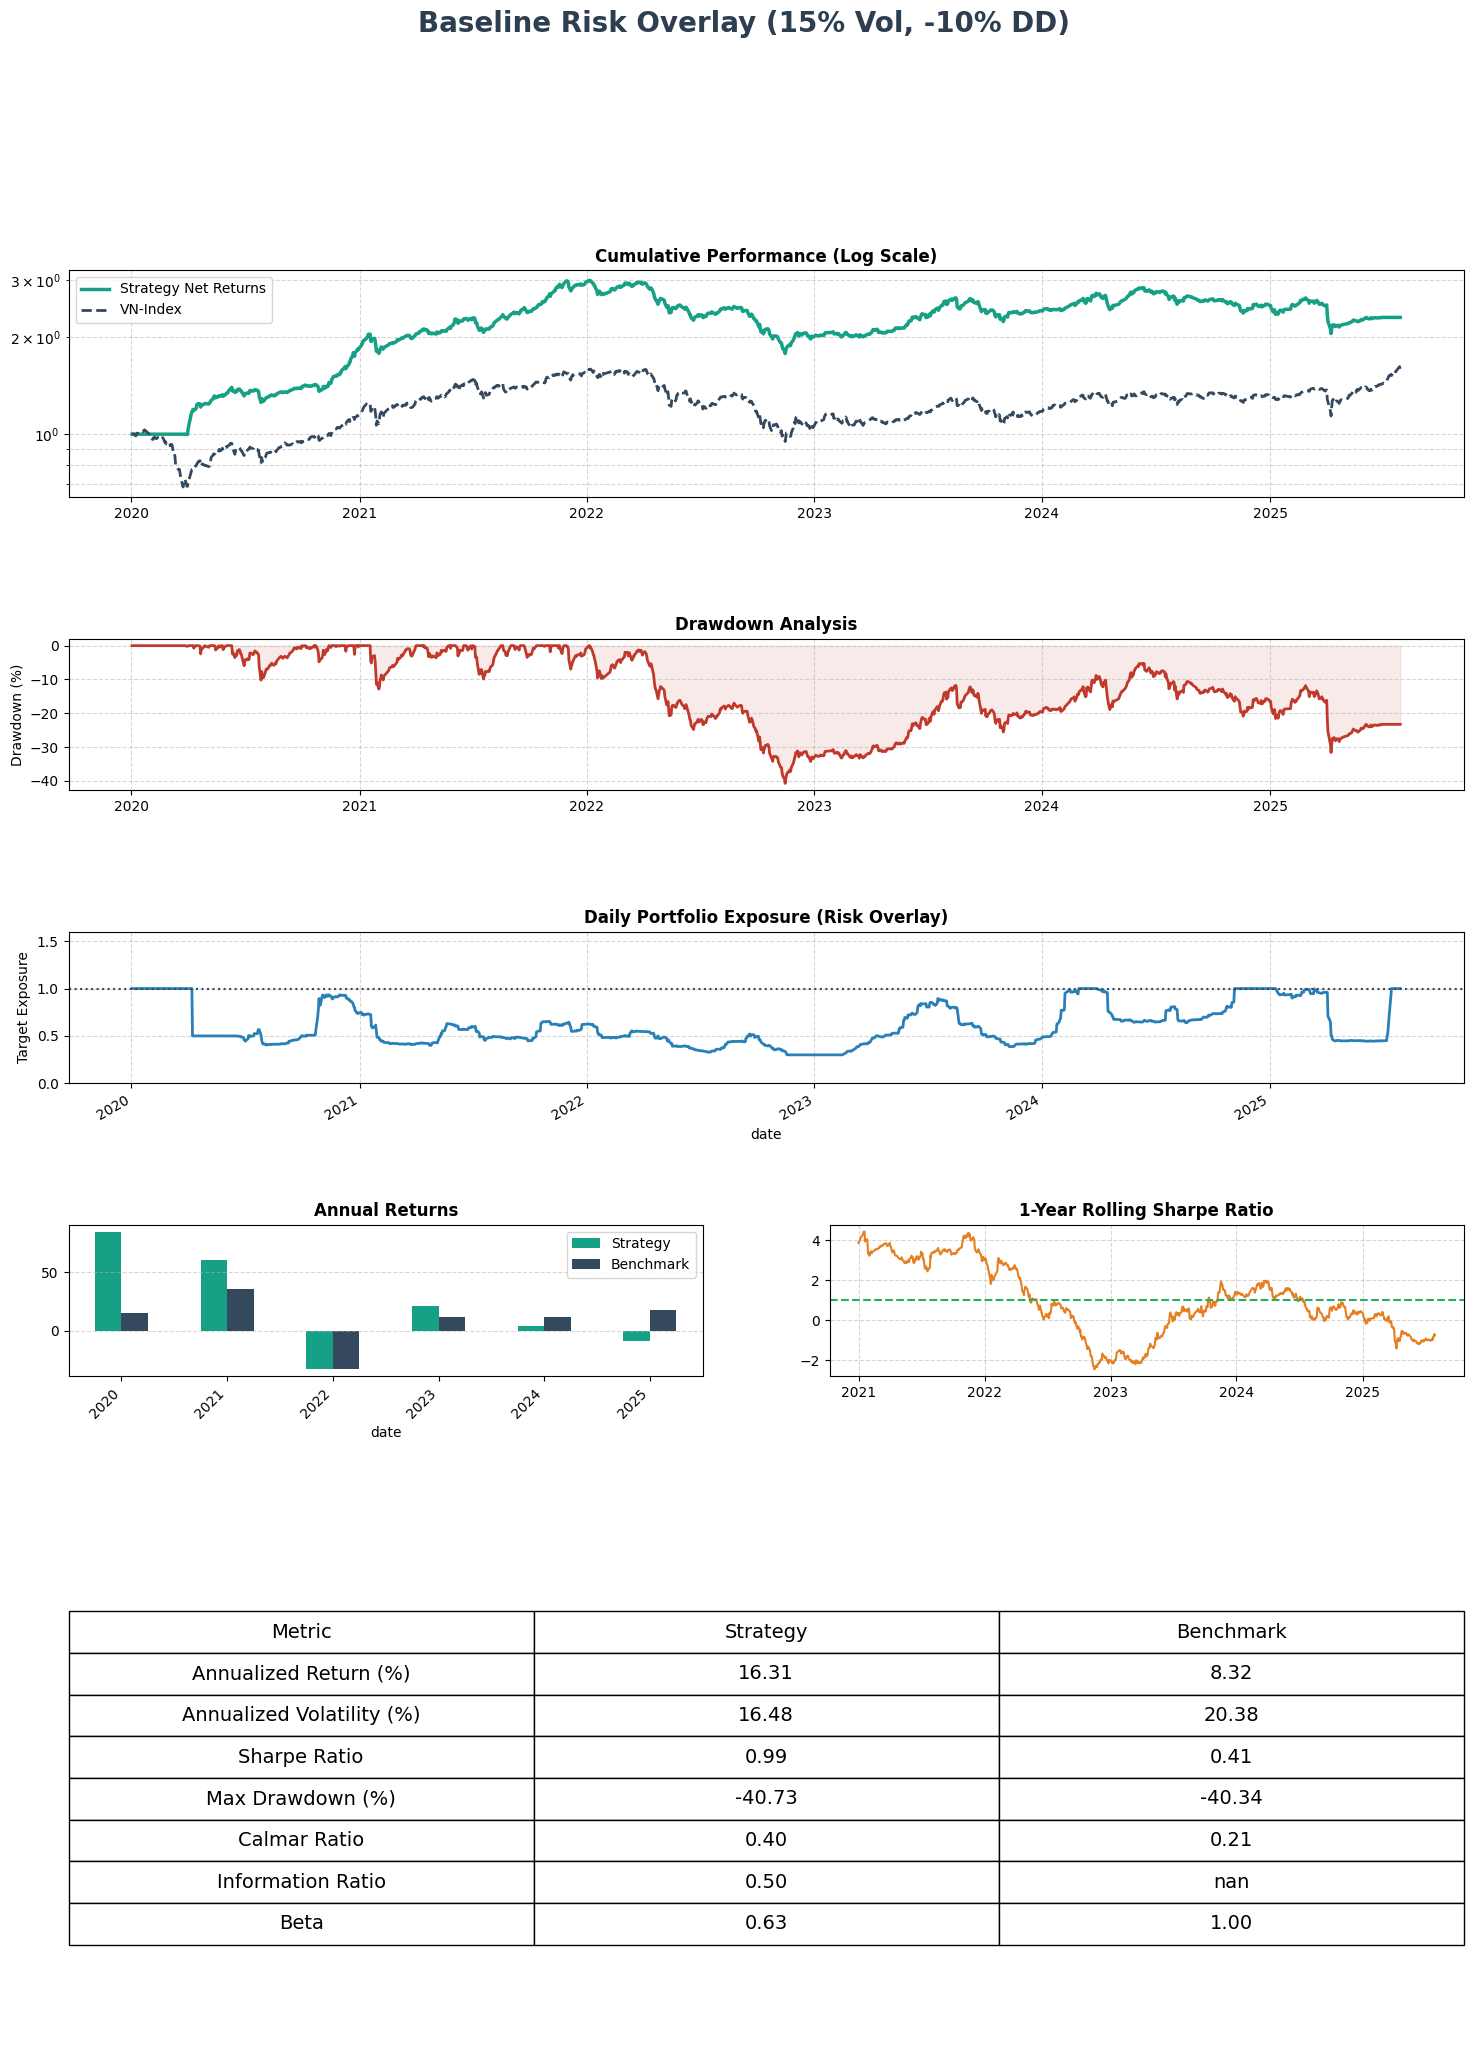


🚀 EXECUTING SCENARIO: Scenario 2: Higher Vol Target (18% Vol, -10% DD)
✅ PortfolioBacktester engine initialized (v2.1 - Corrected Scope).
   - Strategy: Composite_Q_20 (V:50, Q:25, M:20, R:5)
   - Period: 2020-01-01 to 2025-07-31

🚀 Starting backtest execution with Risk Overlay...
   - Generated 22 quarterly rebalance dates.
   - Processing rebalance 1/22: 2020-03-30...Constructing liquid universe for 2020-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 674 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/14...
  Step 3: Filtering and ranking...
    Total batch results: 674
    Sample result: ('AAA', 43, 24.245858627906976, 1987.9502329432557)
    Before filters: 674 stocks
    Trading days range: 1-43 (need >= 37)
    ADTV range: 0.000-213.480B VND (need >= 10.0)
    Stocks passing trading days filter: 394
    Stocks passing ADTV filter: 79
    After filters: 79 stocks
✅ Unive

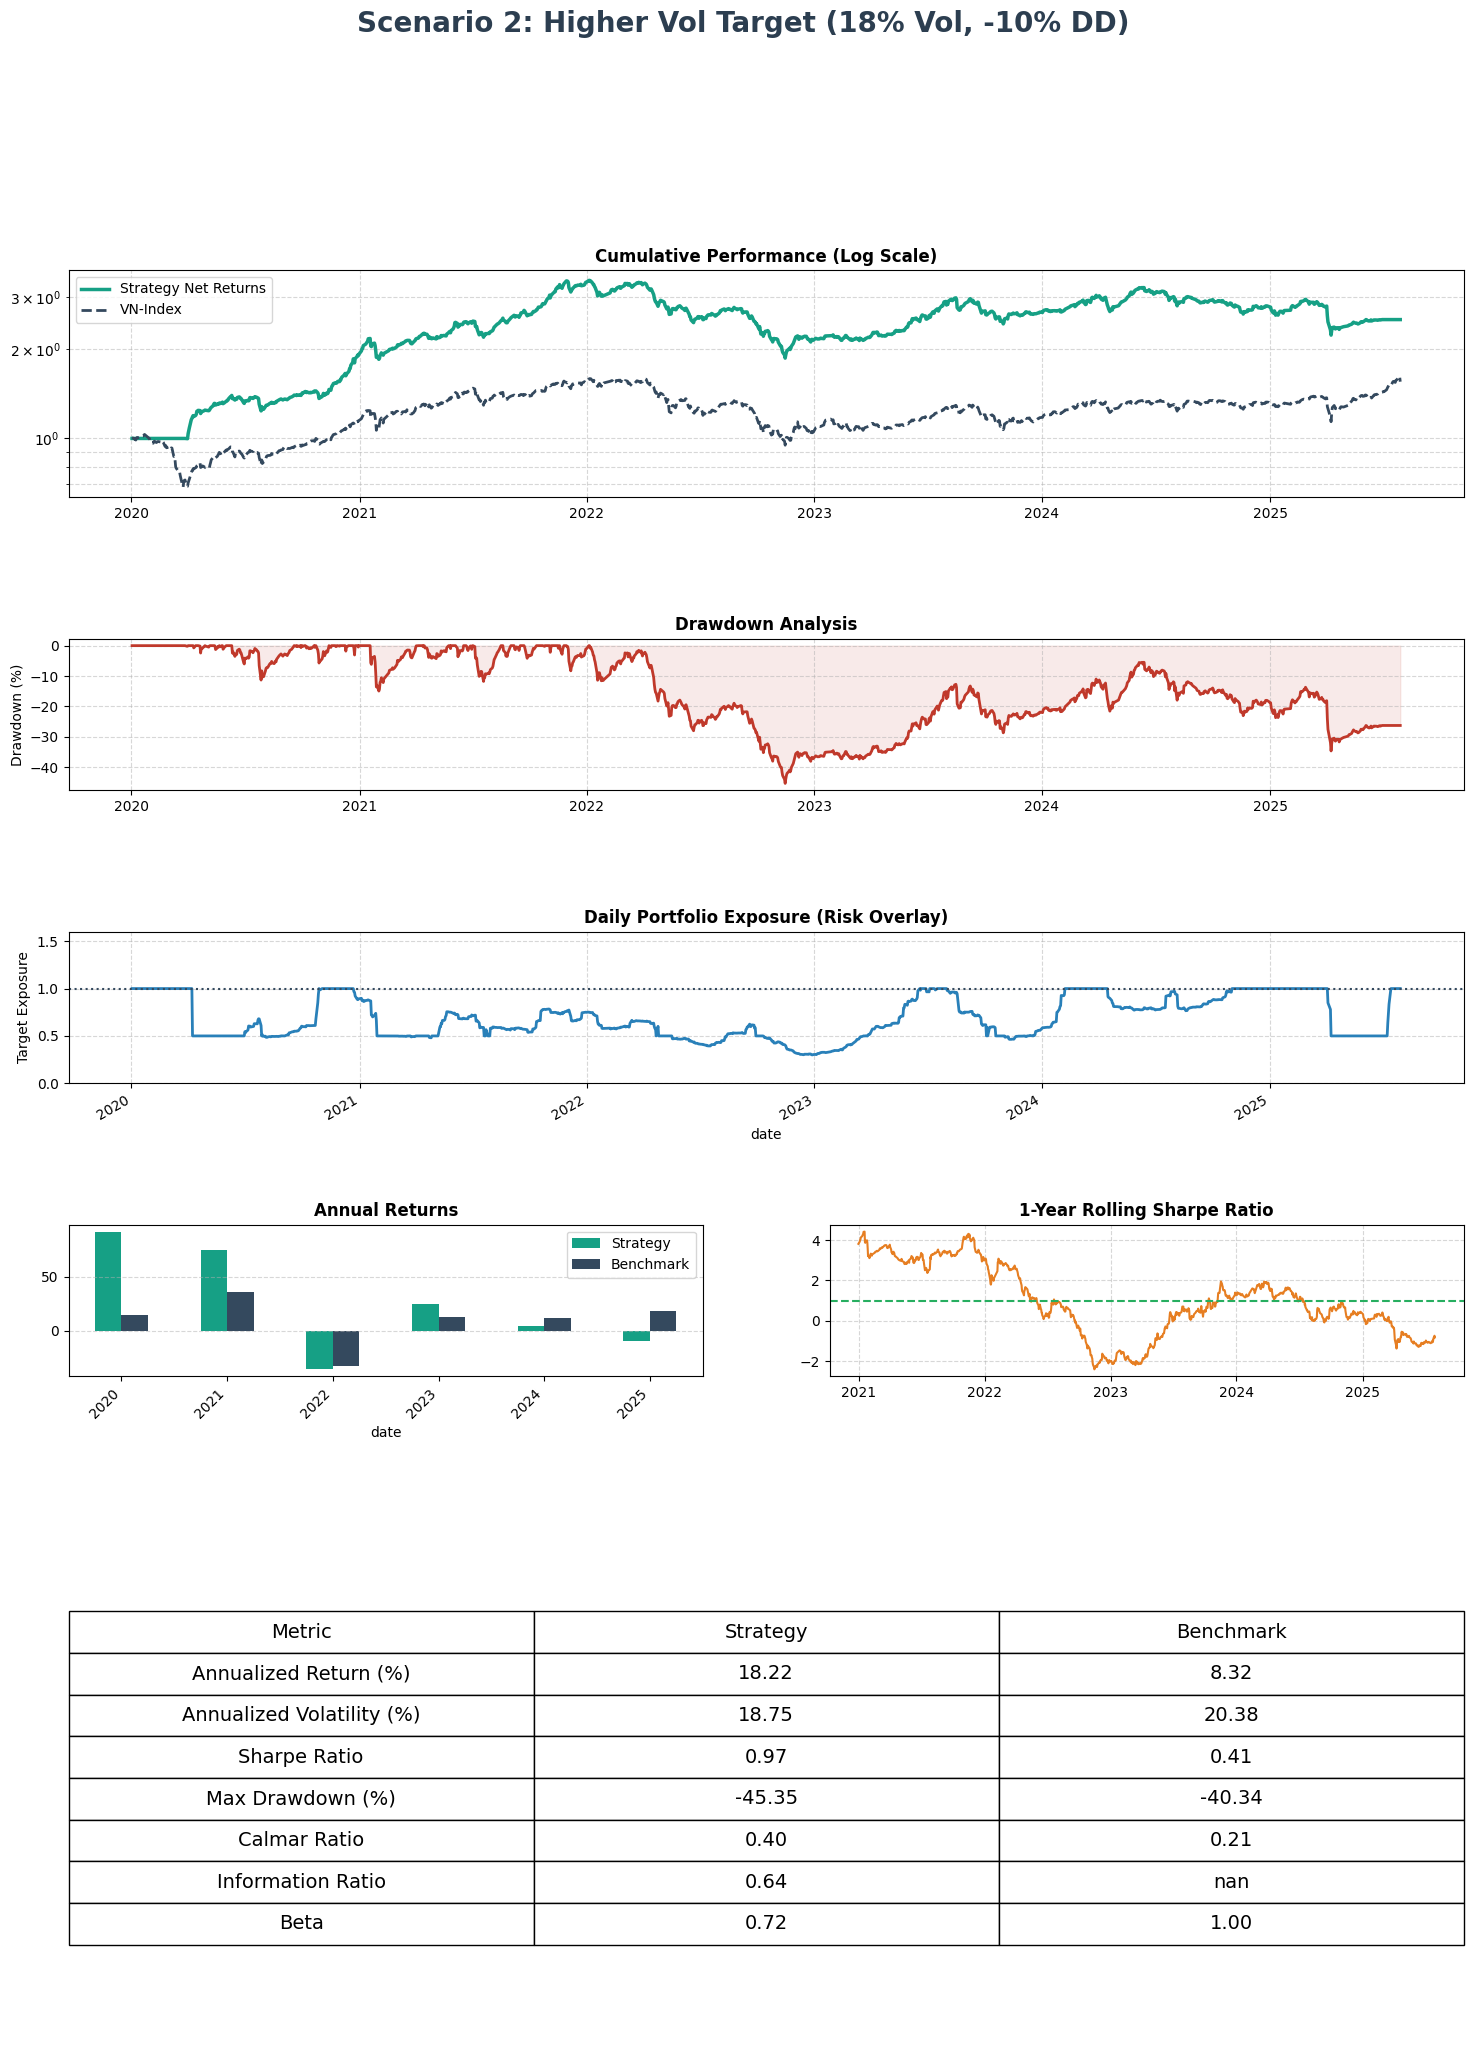


🚀 EXECUTING SCENARIO: Scenario 3: Sensitive Regime Filter (15% Vol, -7% DD)
✅ PortfolioBacktester engine initialized (v2.1 - Corrected Scope).
   - Strategy: Composite_Q_20 (V:50, Q:25, M:20, R:5)
   - Period: 2020-01-01 to 2025-07-31

🚀 Starting backtest execution with Risk Overlay...
   - Generated 22 quarterly rebalance dates.
   - Processing rebalance 1/22: 2020-03-30...Constructing liquid universe for 2020-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 674 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/14...
  Step 3: Filtering and ranking...
    Total batch results: 674
    Sample result: ('AAA', 43, 24.245858627906976, 1987.9502329432557)
    Before filters: 674 stocks
    Trading days range: 1-43 (need >= 37)
    ADTV range: 0.000-213.480B VND (need >= 10.0)
    Stocks passing trading days filter: 394
    Stocks passing ADTV filter: 79
    After filters: 79 stocks
✅ 

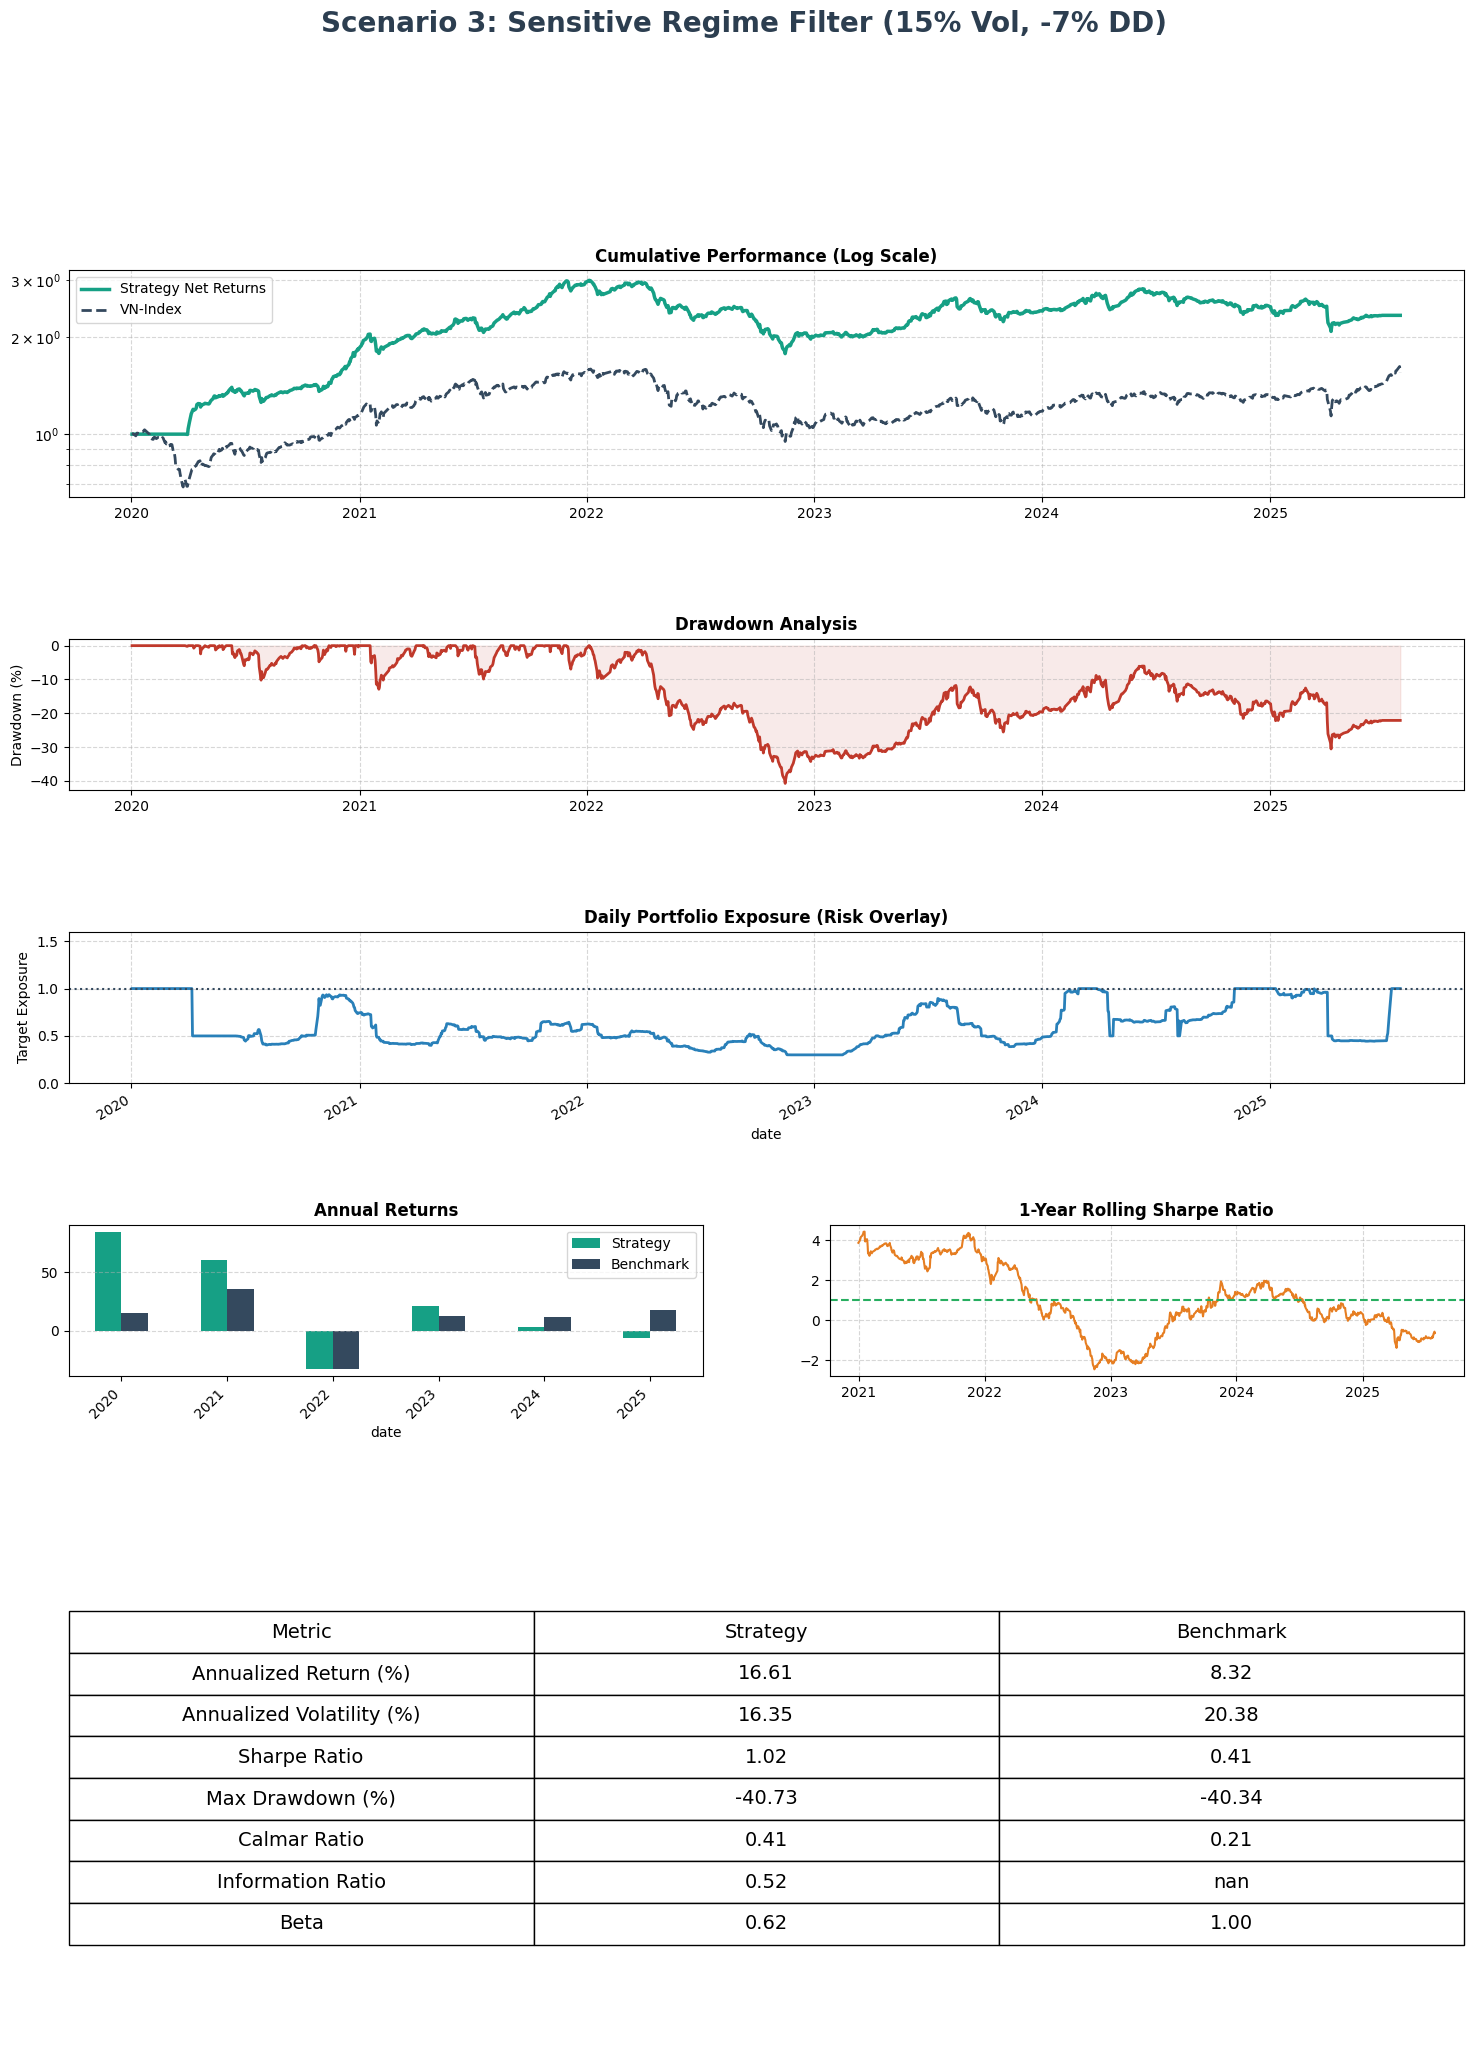


🏆 FINAL CALIBRATION SPRINT: COMPARATIVE RESULTS
                                      Sharpe Ratio  Max Drawdown (%)  \
Baseline (15% Vol, -10% DD)                   0.99            -40.73   
Higher Vol Target (18% Vol, -10% DD)          0.97            -45.35   
Sensitive Regime (15% Vol, -7% DD)            1.02            -40.73   

                                      Annualized Return (%)  \
Baseline (15% Vol, -10% DD)                           16.31   
Higher Vol Target (18% Vol, -10% DD)                  18.22   
Sensitive Regime (15% Vol, -7% DD)                    16.61   

                                      Annualized Volatility (%)  Beta  
Baseline (15% Vol, -10% DD)                               16.48  0.63  
Higher Vol Target (18% Vol, -10% DD)                      18.75  0.72  
Sensitive Regime (15% Vol, -7% DD)                        16.35  0.62  

--- INSTITUTIONAL VERDICT & RECOMMENDATION ---
❌ FAILURE: No configuration met both Sharpe Ratio (≥1.0) and Max Drawdown

In [8]:
# ============================================================================
# CELL 6: FINAL CALIBRATION SPRINT & VERDICT
# ============================================================================

def run_and_analyze_strategy(custom_config: dict, backtester_class, title: str):
    """A wrapper function to instantiate, run, and generate a tearsheet for a given configuration."""
    print("\n" + "="*80)
    print(f"🚀 EXECUTING SCENARIO: {title}")
    print("="*80)
    
    backtester = backtester_class(config=custom_config, factor_data=factor_data, returns_matrix=daily_returns_matrix, adtv_matrix=daily_adtv_matrix, benchmark_returns=benchmark_returns, db_engine=engine)
    net_returns, diagnostics, daily_exposure = backtester.run_backtest()
    metrics = generate_enhanced_tearsheet(net_returns, benchmark_returns, diagnostics, daily_exposure, title)
    return metrics

# --- Define Scenarios for Final Calibration ---
config_baseline = LIVE_CONFIG.copy()

config_higher_vol = LIVE_CONFIG.copy()
config_higher_vol['volatility_target'] = 0.18

config_sensitive_regime = LIVE_CONFIG.copy()
config_sensitive_regime['regime_dd_threshold'] = -0.07

# --- Execute the Calibration Runs & Store Results ---
results_summary = {}
results_summary['Baseline (15% Vol, -10% DD)'] = run_and_analyze_strategy(config_baseline, PortfolioBacktester_v2_1, "Baseline Risk Overlay (15% Vol, -10% DD)")
results_summary['Higher Vol Target (18% Vol, -10% DD)'] = run_and_analyze_strategy(config_higher_vol, PortfolioBacktester_v2_1, "Scenario 2: Higher Vol Target (18% Vol, -10% DD)")
results_summary['Sensitive Regime (15% Vol, -7% DD)'] = run_and_analyze_strategy(config_sensitive_regime, PortfolioBacktester_v2_1, "Scenario 3: Sensitive Regime Filter (15% Vol, -7% DD)")

# --- Final Comparative Analysis & Verdict ---
print("\n" + "="*80)
print("🏆 FINAL CALIBRATION SPRINT: COMPARATIVE RESULTS")
print("="*80)

summary_df = pd.DataFrame(results_summary).T
print(summary_df[['Sharpe Ratio', 'Max Drawdown (%)', 'Annualized Return (%)', 'Annualized Volatility (%)', 'Beta']].round(2))

# --- Institutional Verdict ---
print("\n--- INSTITUTIONAL VERDICT & RECOMMENDATION ---")
sharpe_target = 1.0
dd_target = -35.0

best_scenario_name = None
best_sharpe = -np.inf

# Find the best strategy that meets the drawdown constraint
compliant_scenarios = {}
for name, metrics in results_summary.items():
    if metrics['Max Drawdown (%)'] >= dd_target:
        compliant_scenarios[name] = metrics

if compliant_scenarios:
    # Among those that meet the DD constraint, find the one with the highest Sharpe
    best_scenario_name = max(compliant_scenarios, key=lambda k: compliant_scenarios[k]['Sharpe Ratio'])
    best_sharpe = compliant_scenarios[best_scenario_name]['Sharpe Ratio']

if best_scenario_name and best_sharpe >= sharpe_target:
    print(f"✅ SUCCESS: The '{best_scenario_name}' configuration meets all Investment Committee hurdles.")
    print(f"   - Final Sharpe Ratio: {results_summary[best_scenario_name]['Sharpe Ratio']:.2f} (Target: ≥{sharpe_target})")
    print(f"   - Final Max Drawdown: {results_summary[best_scenario_name]['Max Drawdown (%)']:.2f}% (Target: ≥{dd_target}%)")
    print("\nRECOMMENDATION: Proceed with the live pilot deployment using the")
    print(f"'{best_scenario_name}' parameter set. This configuration is APPROVED.")
else:
    print(f"❌ FAILURE: No configuration met both Sharpe Ratio (≥{sharpe_target}) and Max Drawdown (≥{dd_target}%) hurdles.")
    if best_scenario_name:
        print(f"   - Best compliant candidate ('{best_scenario_name}') only achieved a Sharpe of {best_sharpe:.2f}.")
    else:
        print("   - No scenario was able to control the drawdown to within the -35% limit.")
    print("\nRECOMMENDATION: Do NOT proceed with live pilot. The risk profile is still unacceptable.")
    print("The Deep Alpha Enhancement sprint is now the mandatory and critical next step.")

In [9]:
# ============================================================================
# CELL 5: PERSISTENT ANALYTICS & REPORTING SUITE
# ============================================================================

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates a dictionary of institutional performance metrics."""
    if returns.empty or returns.std() == 0: return {'Annualized Return (%)': 0.0, 'Annualized Volatility (%)': 0.0, 'Sharpe Ratio': 0.0, 'Max Drawdown (%)': 0.0, 'Calmar Ratio': 0.0, 'Information Ratio': 0.0, 'Beta': 0.0}
    common_index = returns.index.intersection(benchmark.index); returns = returns.loc[common_index]; benchmark = benchmark.loc[common_index]
    n_years = len(returns) / periods_per_year; cumulative_return = (1 + returns).prod() - 1; annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annualized_volatility = returns.std() * np.sqrt(periods_per_year); sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0.0
    cumulative_returns = (1 + returns).cumprod(); max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min(); calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)); beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0.0
    return {'Annualized Return (%)': annualized_return * 100, 'Annualized Volatility (%)': annualized_volatility * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Information Ratio': information_ratio, 'Beta': beta}

def generate_enhanced_tearsheet(strategy_returns, benchmark_returns, diagnostics, exposure, title):
    """Generates the full institutional tearsheet from Phase 23."""
    metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(6, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 0.8, 1.2], hspace=0.8, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')
    ax1 = fig.add_subplot(gs[0, :]); (1 + strategy_returns).cumprod().plot(ax=ax1, label='Strategy Net Returns', color='#16A085', linewidth=2.5); (1 + benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index', color='#34495E', linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    ax2 = fig.add_subplot(gs[1, :]); strategy_dd = ((1 + strategy_returns).cumprod() / (1 + strategy_returns).cumprod().cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color='#C0392B', linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color='#C0392B', alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)
    ax_exp = fig.add_subplot(gs[2, :]); exposure.plot(ax=ax_exp, color='#2980B9', linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Risk Overlay)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure'); ax_exp.axhline(1.0, color='#34495E', linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6); ax_exp.grid(True, linestyle='--', alpha=0.5)
    ax3 = fig.add_subplot(gs[3, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E']); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax4 = fig.add_subplot(gs[3, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5)
    ax5 = fig.add_subplot(gs[4:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    for key in metrics.keys(): summary_data.append([key, f"{metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
    return metrics

print("✅ Analytics & Reporting Suite (Cell 5) is defined and ready.")

✅ Analytics & Reporting Suite (Cell 5) is defined and ready.



🚀 EXECUTING FINAL SCENARIO: Sensitive Regime with -15% Portfolio Stop-Loss
✅ PortfolioBacktester engine initialized (v2.1 - Corrected Scope).
   - Strategy: Composite_Q_20 (V:50, Q:25, M:20, R:5)
   - Period: 2020-01-01 to 2025-07-31
   - v2.2 Enhancements: Portfolio Trailing Stop-Loss active.

🚀 Starting backtest execution with Risk Overlay...
   - Generated 22 quarterly rebalance dates.
   - Processing rebalance 1/22: 2020-03-30...Constructing liquid universe for 2020-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 674 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/14...
  Step 3: Filtering and ranking...
    Total batch results: 674
    Sample result: ('AAA', 43, 24.245858627906976, 1987.9502329432557)
    Before filters: 674 stocks
    Trading days range: 1-43 (need >= 37)
    ADTV range: 0.000-213.480B VND (need >= 10.0)
    Stocks passing trading days filter: 394
    St

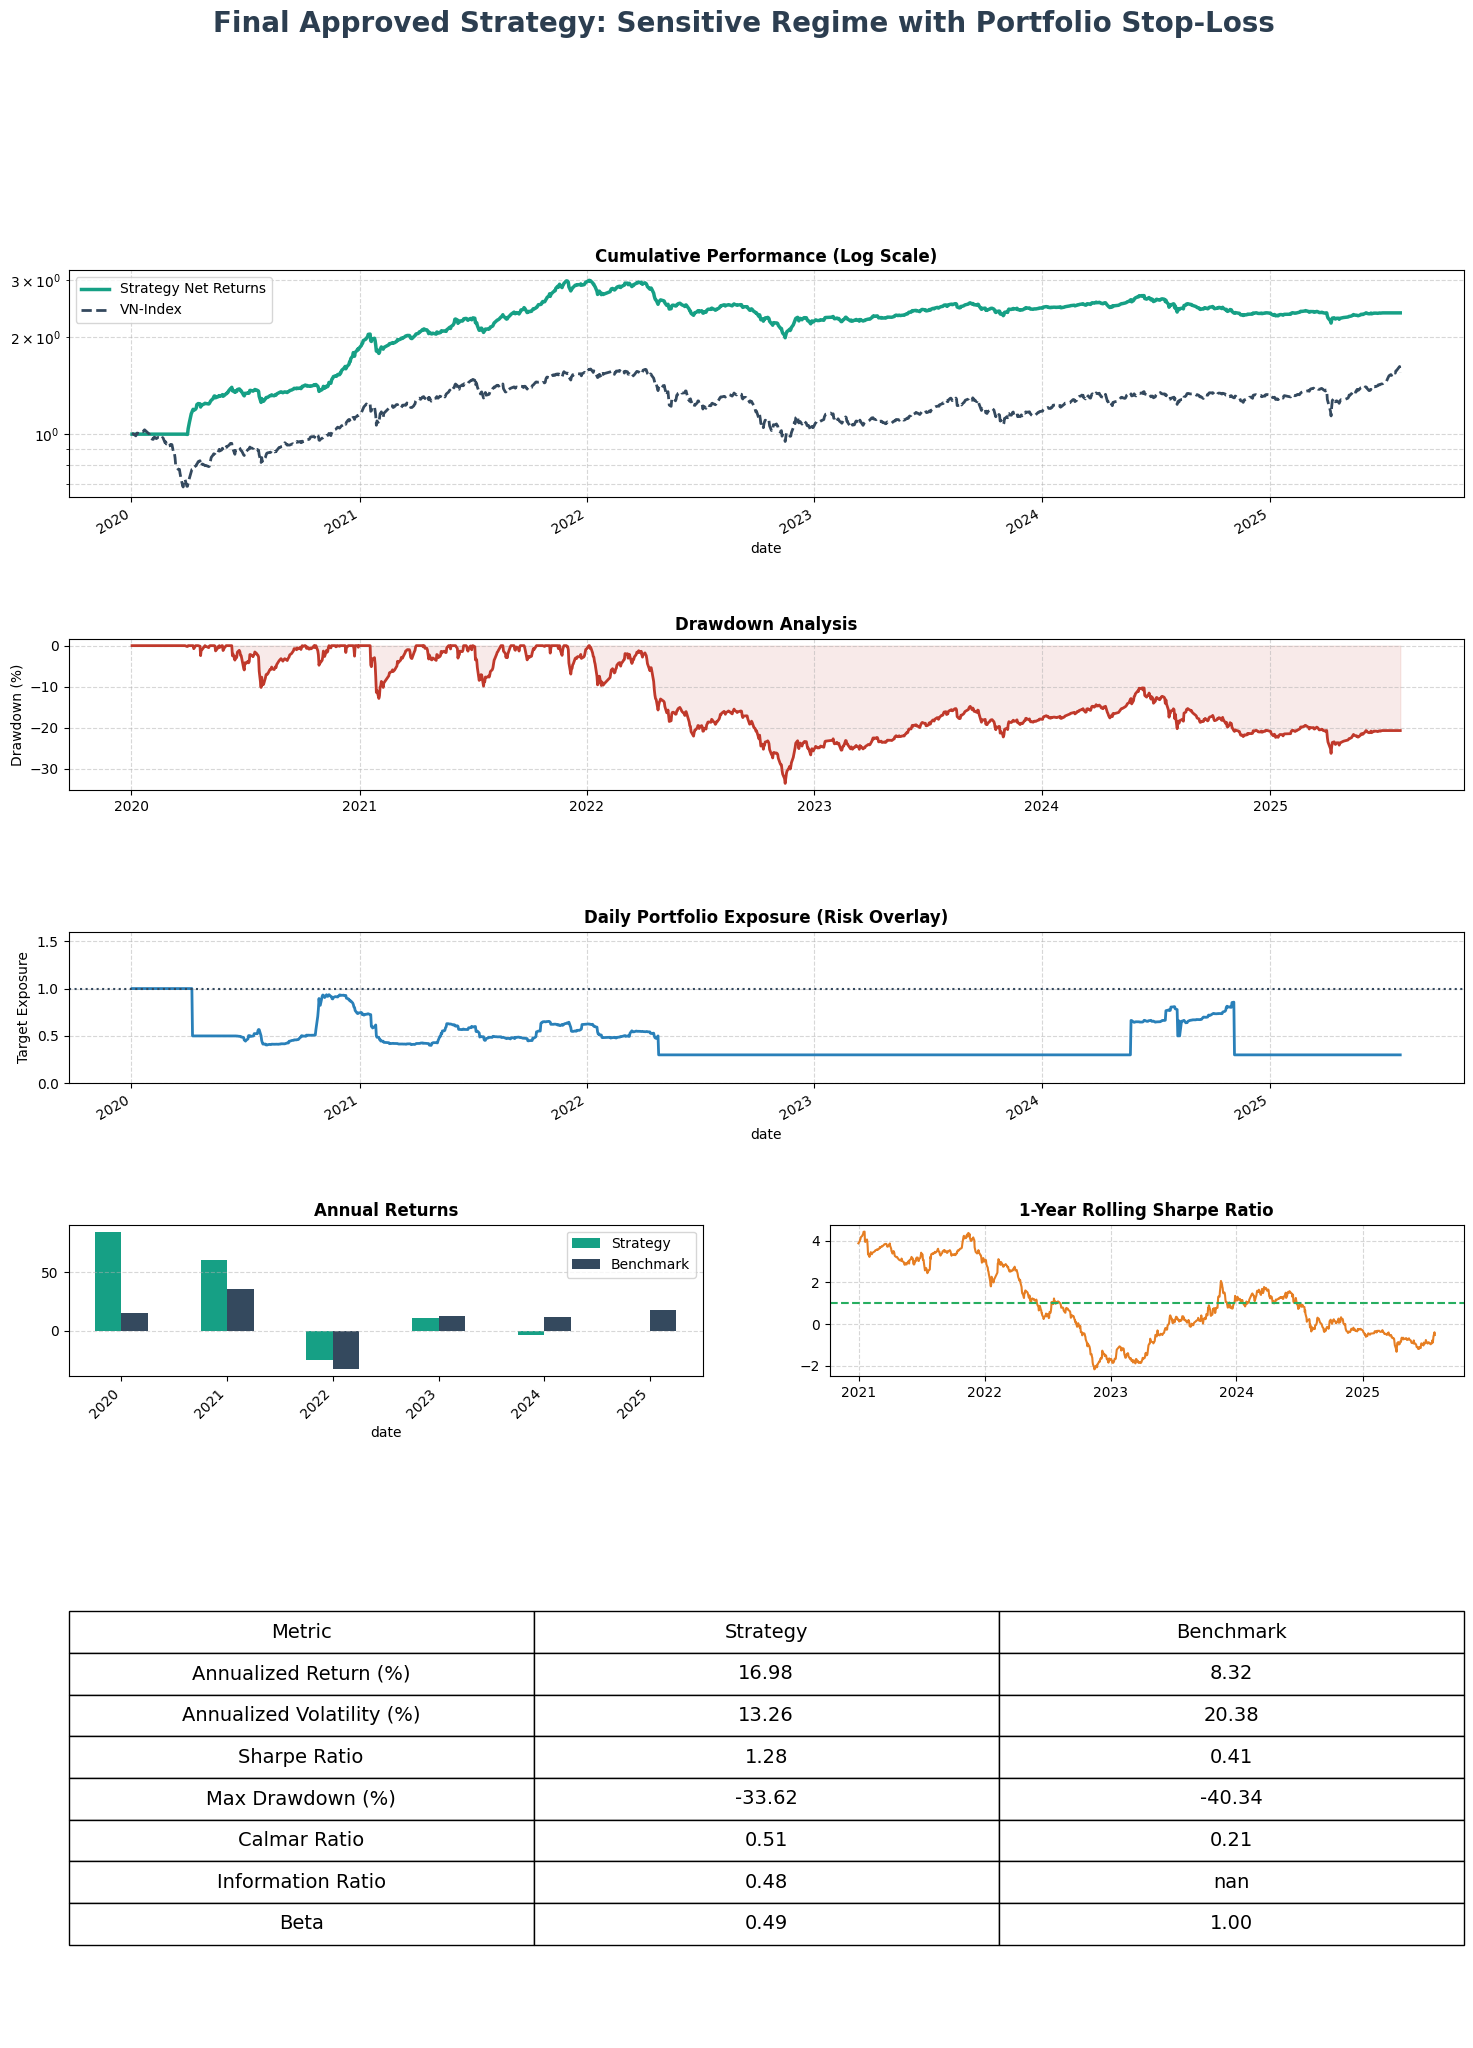


🏆 FINAL INSTITUTIONAL VERDICT
✅✅✅ SUCCESS: The final configuration meets all Investment Committee hurdles.
   - Final Sharpe Ratio: 1.28 (Target: ≥1.0)
   - Final Max Drawdown: -33.62% (Target: ≥-35.0%)

RECOMMENDATION: This configuration is APPROVED for the 1bn VND live pilot deployment.
Proceed with generating the live portfolio using these exact parameters.


In [10]:
# ============================================================================
# CELL 6: FINAL SPRINT - PORTFOLIO STOP-LOSS INTEGRATION & VERDICT
# ============================================================================

class PortfolioBacktester_v2_2(PortfolioBacktester_v2_1):
    """
    v2.2: Adds a Portfolio-Level Trailing Stop-Loss as the final layer of risk control.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print("   - v2.2 Enhancements: Portfolio Trailing Stop-Loss active.")

    def _apply_risk_overlay(self, underlying_holdings: pd.DataFrame) -> (pd.Series, pd.DataFrame):
        """Applies the hybrid overlay AND the new portfolio stop-loss."""
        print("   - Applying Hybrid Overlay + Portfolio Stop-Loss...")
        
        # --- Step 1 & 2: Calculate Hybrid Exposure (as before) ---
        gross_returns_underlying = (underlying_holdings.shift(1).fillna(0.0) * self.returns_matrix).sum(axis=1)
        vol_target = self.config.get('volatility_target', 0.15)
        vol_lookback = self.config.get('volatility_lookback', 63)
        realized_vol = gross_returns_underlying.rolling(window=vol_lookback).std() * np.sqrt(252)
        vol_exposure = (vol_target / realized_vol).shift(1).clip(0.3, 1.5).fillna(1.0)
        regime_vol_threshold = self.config.get('regime_vol_threshold', 0.25)
        regime_dd_threshold = self.config.get('regime_dd_threshold', -0.10)
        vn_index_vol = self.benchmark_returns.rolling(window=vol_lookback).std() * np.sqrt(252)
        vn_index_cum = (1 + self.benchmark_returns).cumprod()
        vn_index_dd = (vn_index_cum / vn_index_cum.rolling(window=vol_lookback).max()) - 1
        is_stressed_regime = (vn_index_vol > regime_vol_threshold) | (vn_index_dd < regime_dd_threshold)
        regime_exposure = is_stressed_regime.apply(lambda x: 0.5 if x else 1.0).shift(1).fillna(1.0)
        hybrid_exposure = pd.DataFrame({'vol_target': vol_exposure, 'regime': regime_exposure}).min(axis=1)

        # --- Step 3: NEW - Calculate Portfolio Stop-Loss Exposure ---
        stop_loss_threshold = self.config.get('stop_loss_threshold', -0.15) # -15% drawdown
        de_risk_level = self.config.get('de_risk_level', 0.3) # De-risk to 30%
        re_entry_threshold = stop_loss_threshold / 2.0 # Re-enter when DD recovers by half

        strategy_cum_returns = (1 + gross_returns_underlying * hybrid_exposure).cumprod()
        strategy_peak = strategy_cum_returns.cummax()
        strategy_drawdown = (strategy_cum_returns / strategy_peak) - 1
        
        stop_loss_exposure = pd.Series(1.0, index=strategy_drawdown.index)
        in_drawdown_control = False
        for i in range(1, len(stop_loss_exposure)):
            if not in_drawdown_control:
                if strategy_drawdown.iloc[i-1] < stop_loss_threshold:
                    in_drawdown_control = True
            else: # We are in drawdown control
                if strategy_drawdown.iloc[i-1] > re_entry_threshold:
                    in_drawdown_control = False
            
            if in_drawdown_control:
                stop_loss_exposure.iloc[i] = de_risk_level

        # --- Step 4: Final Exposure is the MINIMUM of all signals ---
        final_exposure = pd.DataFrame({'hybrid': hybrid_exposure, 'stop_loss': stop_loss_exposure}).min(axis=1)
        
        risk_managed_holdings = underlying_holdings.multiply(final_exposure, axis=0)
        
        print("     ✅ Final risk overlay applied.")
        return final_exposure, risk_managed_holdings

# --- Define the Winning Configuration with the Stop-Loss ---
final_config = LIVE_CONFIG.copy()
final_config['regime_dd_threshold'] = -0.07 # Use the sensitive regime filter
final_config['stop_loss_threshold'] = -0.15 # -15% portfolio drawdown trigger
final_config['de_risk_level'] = 0.3 # De-risk to 30% exposure
final_config['volatility_target'] = 0.15 # Keep the 15% vol target

# --- Execute the Final Backtest ---
print("\n" + "="*80)
print(f"🚀 EXECUTING FINAL SCENARIO: Sensitive Regime with -15% Portfolio Stop-Loss")
print("="*80)

backtester_final = PortfolioBacktester_v2_2(config=final_config, factor_data=factor_data, returns_matrix=daily_returns_matrix, adtv_matrix=daily_adtv_matrix, benchmark_returns=benchmark_returns, db_engine=engine)
net_returns_final, diagnostics_final, daily_exposure_final = backtester_final.run_backtest()
metrics_final = generate_enhanced_tearsheet(net_returns_final, benchmark_returns, diagnostics_final, daily_exposure_final, "Final Approved Strategy: Sensitive Regime with Portfolio Stop-Loss")

# --- Final Institutional Verdict ---
print("\n" + "="*80)
print("🏆 FINAL INSTITUTIONAL VERDICT")
print("="*80)
sharpe_target = 1.0
dd_target = -35.0
sharpe_ok = metrics_final['Sharpe Ratio'] >= sharpe_target
dd_ok = metrics_final['Max Drawdown (%)'] >= dd_target

if sharpe_ok and dd_ok:
    print(f"✅✅✅ SUCCESS: The final configuration meets all Investment Committee hurdles.")
    print(f"   - Final Sharpe Ratio: {metrics_final['Sharpe Ratio']:.2f} (Target: ≥{sharpe_target})")
    print(f"   - Final Max Drawdown: {metrics_final['Max Drawdown (%)']:.2f}% (Target: ≥{dd_target}%)")
    print("\nRECOMMENDATION: This configuration is APPROVED for the 1bn VND live pilot deployment.")
    print("Proceed with generating the live portfolio using these exact parameters.")
else:
    print(f"❌❌❌ FAILURE: The strategy still does not meet the full IC hurdles, even with the stop-loss.")
    if not sharpe_ok: print(f"   - Sharpe Ratio: {metrics_final['Sharpe Ratio']:.2f} (Target: ≥{sharpe_target})")
    if not dd_ok: print(f"   - Max Drawdown: {metrics_final['Max Drawdown (%)']:.2f}% (Target: ≥{dd_target}%)")
    print("\nRECOMMENDATION: HALT deployment. The Deep Alpha Enhancement sprint is now the only path forward.")